# 0. Importing packages

In [1]:
from scipy.optimize import differential_evolution
import numpy as np
from matplotlib import pyplot as plt

from packages.functions import calcL1MET, cache
import optimisation as opt

Importing packages


# 1. Loading data

In [96]:
data2024 = "/shared/scratch/wq22321/data/NANOAOD_Muon0Run2023D_ZMu_PromptReco_v2RAW_RECO_2023_v0_4/231121_100830/0000/out_10.root"
fit, _ = opt.prepareInputs(dir = data2024, subset=1.0, cuts=(0, 300))

Reading in calo tower data
Reading in PUPPI MET pT and phi
Calculating x and y components of PUPPI MET
Reading in muon pT and phi
Calculating muon ptx and pty for each event
Calculating PUPPI MET no Mu and reformatting data


/users/wq22321/methackathon_2024/packages/functions.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfcand_muons['muon_ptx'] = np.cos(pfcand_muons['Muon_phi']) * pfcand_muons['Muon_pt']
/users/wq22321/methackathon_2024/packages/functions.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pfcand_muons['muon_pty'] = np.sin(pfcand_muons['Muon_phi']) * pfcand_muons['Muon_pt']


Subsetting events
Calculating NTT4


In [25]:
calo, puppi, ntt4 = fit

In [4]:
cache(mode="write", datCollection=fit)

Writing calo to /shared/scratch/wq22321/cached_MET_data/calo.csv


Writing puppi to /shared/scratch/wq22321/cached_MET_data/puppi.csv
Writing ntt4 to /shared/scratch/wq22321/cached_MET_data/ntt4.csv


In [5]:
calo, puppi, ntt4 = cache(mode="read")

In [10]:
ntt4

,ntt4
0,17.0
1,22.0
2,14.0
3,16.0
4,15.0
...,...
5301,22.0
5302,12.0
5303,14.0
5304,17.0


In [14]:
puppi

,puppi_MetNoMu
0,30.955175
1,74.999069
2,11.730311
3,22.371643
4,29.721386
...,...
5301,58.730568
5302,50.574310
5303,62.798317
5304,104.426521


# 2. Optimisation

In [97]:
print("Starting optimisation")

bounds = [(0, 3), (0, 4), (0, 3), (0, 4)]
x0 = (2.0, 2.0, 0.5, 2.0)
turn_on_options = (True, 60, 0.1)
result = differential_evolution(
    func     = opt.objective,
    bounds   = bounds,
    args     = (fit, turn_on_options),
    
    x0 = x0,
    popsize  = 15,    # 15
    maxiter  = 10,    # 1000
    strategy = "best1bin",    # "best1bin"
    init     = "sobol",    #"latinhypercube"
    disp     = True,
    workers  = 8,    # 1
    polish   = False
    )

print(result.x)
print(result)

Starting optimisation


/users/wq22321/methackathon_2024/.venv/lib/python3.9/site-packages/scipy/optimize/_differentialevolution.py:487: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,



Currently trying: a = 2.0, b = 2.0, c = 0.5 and d = 2.0

Currently trying: a = 2.11, b = 0.04, c = 2.46 and d = 0.77

Currently trying: a = 1.04, b = 0.6, c = 1.05 and d = 2.31

Currently trying: a = 2.37, b = 1.17, c = 0.41 and d = 3.63

Currently trying: a = 0.19, b = 0.46, c = 0.65 and d = 0.46

Currently trying: a = 1.54, b = 1.78, c = 0.91 and d = 1.52

Currently trying: a = 1.3, b = 1.34, c = 2.31 and d = 3.06

Currently trying: a = 2.98, b = 0.91, c = 2.24 and d = 2.89
Width: 90.97063903281521

Currently trying: a = 2.71, b = 3.88, c = 1.16 and d = 3.48
Width: 162.25806451612902

Currently trying: a = 1.36, b = 2.32, c = 0.3 and d = 2.53
Width: 92.88915566226493

Currently trying: a = 1.79, b = 2.75, c = 1.71 and d = 0.11
Width: 105.15548172757474

Currently trying: a = 0.12, b = 3.44, c = 2.76 and d = 1.93
Width: 96.63865546218487

Currently trying: a = 2.44, b = 2.17, c = 2.99 and d = 2.23
Width: 94.7229326513214

Currently trying: a = 0.79, b = 3.62, c = 1.56 and d = 3.78
Wi

Process ForkPoolWorker-25:
Process ForkPoolWorker-26:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/software/wq22321/miniconda/lib/python3.9/multiprocessing/pool.py", line 4

KeyboardInterrupt: 

In [ ]:
result.x

# 3. Parameter analysis

In [8]:
def heatmapper(a, b, c, d):
    dat = lookup_gen(a, b, c, d)
    ietas, pu_bins, thresh = zip(*dat)
    plt.figure(figsize=(15,9))
    plt.hist2d(ietas, pu_bins, weights=thresh, bins=[83, 32])
    plt.colorbar()
    #plt.xlim([1,41]); plt.ylim([0,31])
    plt.xlabel("ieta"); plt.ylabel("NTT4 bin")
    plt.title("2D histogram of tower threshold (scaled by tower size)")
    plt.show()

In [9]:
def lookup_gen(a, b, c, d):
    
    all_ieta_vals = np.linspace(-41, 41, 83)
    all_pu_bins = np.linspace(0, 31, 32)
    
    res = []
    for ieta in all_ieta_vals:
        for pu_bin in all_pu_bins:
            thresh = threshold_calc(ieta, pu_bin, a, b, c, d)
            res.append((ieta, pu_bin, thresh))
            
    return res

In [10]:
def threshold_calc(ieta, ntt4, a, b, c, d):
    towerAreas = [    0., # dummy for ieta=0
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,
                  1.03,1.15,1.3,1.48,1.72,2.05,1.72,4.02,
                  0., # dummy for ieta=29
                  3.29,2.01,2.02,2.01,2.02,2.0,2.03,1.99,2.02,2.04,2.00,3.47]
    
    numerator = (towerAreas[int(abs(ieta))]**a) * (ntt4**c)
    denominator = d * (1 + np.exp(-b * (abs(ieta))))
    
    threshold = (numerator / denominator).clip(max=40)
#    return (threshold/2)# / towerAreas[int(abs(ieta))]
    if towerAreas[int(abs(ieta))] == 0:
        return np.nan
    else:
        return (threshold/2)# / towerAreas[int(abs(ieta))]

In [46]:
fw = (0.66881105, 1.77791976, 0.96226907, 2.08912586)
reg = (0.21456065, 2.74961211, 0.47896413, 0.30650943)
old = (1.707, 3.078, 0.195, 1.365)

quick = (2.49418849, 3.06860578, 0.22999811, 3.75036927)
quick2 = (0.4785183 , 2.95870881, 0.19865517, 1.69915227)

zmu23_1 = (1.87, 1.34, 0.1, 2.84)
zmu23_2 = (1.49, 2.91, 0.26, 1.51)
zmu23_3 = (2.34, 2.82, 0.37, 2.79)


rmse = (1.69851912, 2.511431, 0.31321421, 3.70933707)
turnon = (1.54119447, 2.76036528, 0.5173701, 1.42313447)

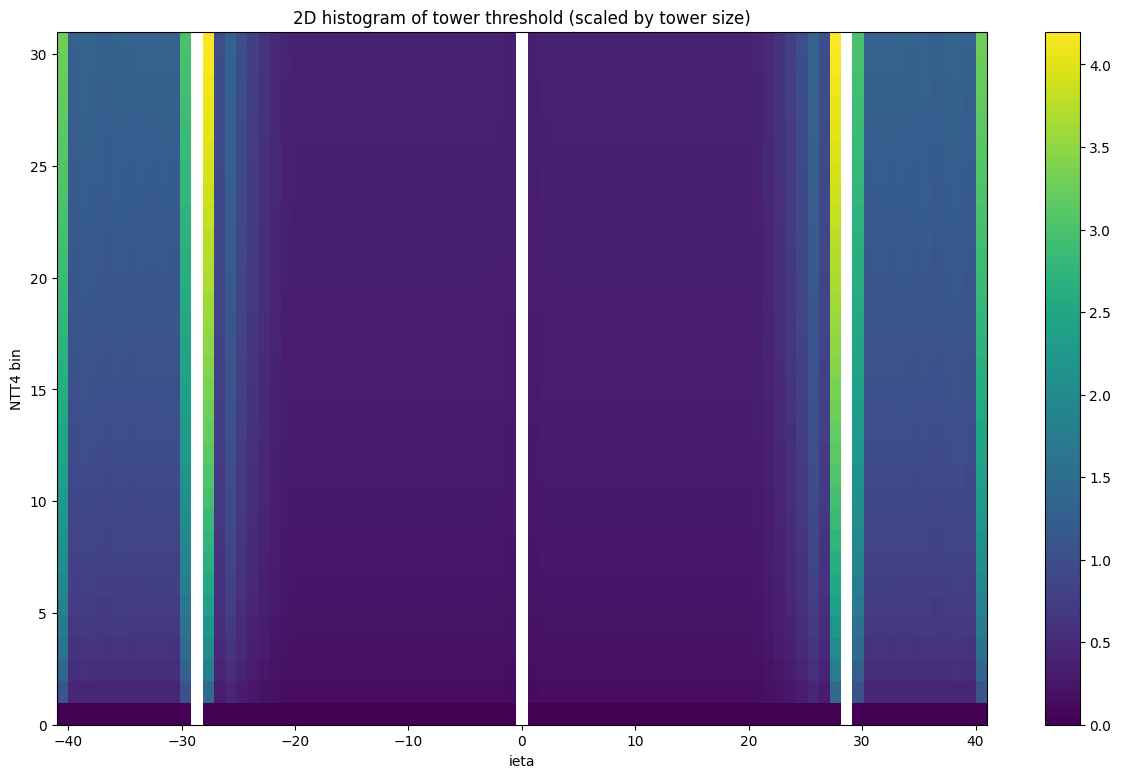

In [12]:
heatmapper(*rmse)

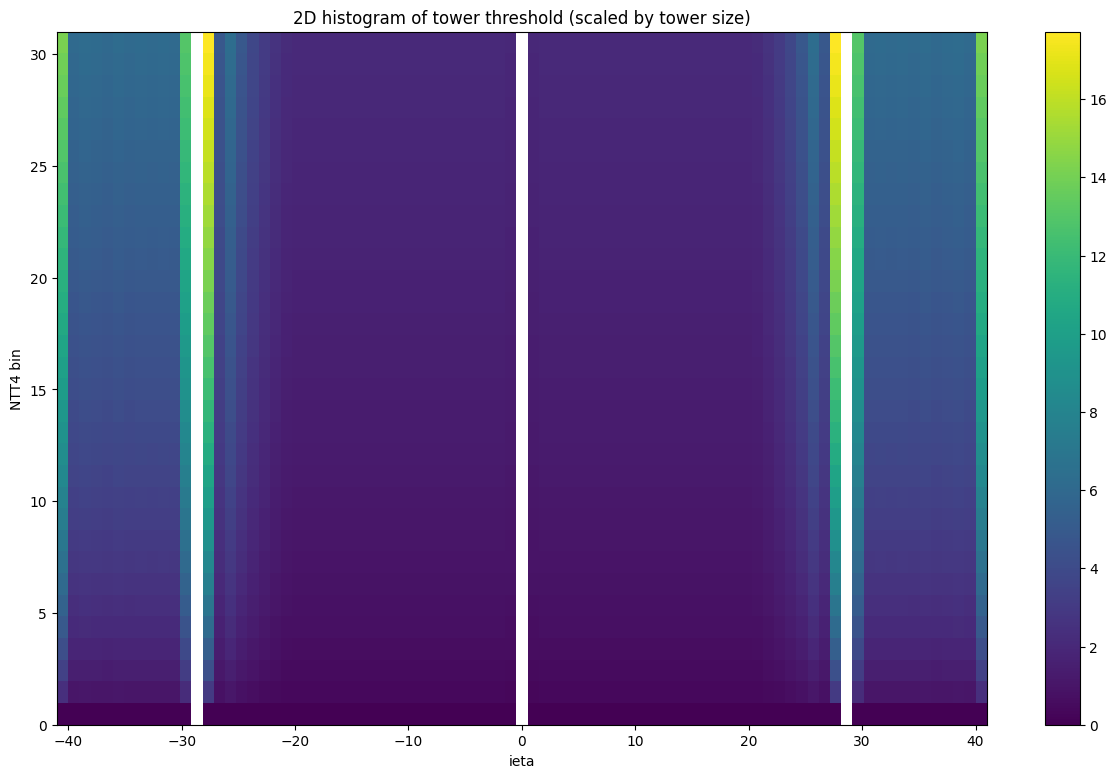

In [13]:
heatmapper(*turnon)

In [28]:
rmse_MET = opt.applyCaloTowerThresh(calo, *rmse)[0]

In [49]:
turnon_MET = opt.applyCaloTowerThresh(calo, *turnon)[0]

In [40]:
def getTurnOn( online, offline, threshold=80 ) :
    offline_bins = np.linspace(0, 300, 31)
    efficiency = []

    for i in range(len(offline_bins) - 1):
        # Define the offline range for this bin
        offline_range = (offline >= offline_bins[i]) & (offline < offline_bins[i + 1])
        # count the number of events passing the threshold in the offline range
        num_offline = sum(offline_range)
        # count the number of events passing the threshold in both online and offline ranges
        num_both = sum((online > threshold) & offline_range)
        # calculate the efficiency as the ratio of online events passing the cut over offline events passing the threshold
        if num_offline > 0:
            eff = num_both / num_offline
        else:
            eff = 0
        efficiency.append(eff)

    bin_centers = (offline_bins[:-1] + offline_bins[1:]) / 2

    return bin_centers, efficiency

In [43]:
bins, eff = getTurnOn(rmse_MET, puppi, threshold=60)

In [53]:
bins2, eff2 = getTurnOn(rmse_MET, puppi, threshold=80)

In [50]:
bins_to, eff_to = getTurnOn(turnon_MET, puppi, threshold=60)

In [51]:
bins_l1, eff_l1 = getTurnOn(l1met, puppi, threshold=60)

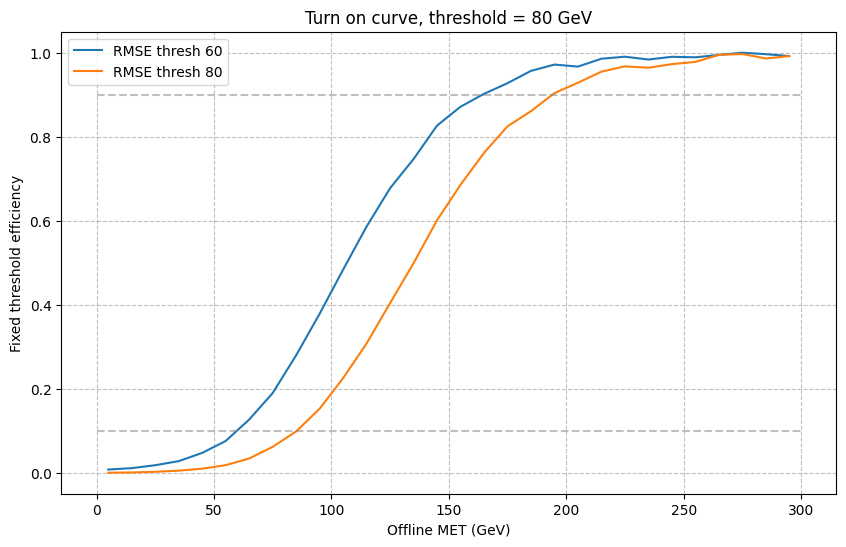

In [98]:
plt.figure(figsize=(10,6))

plt.plot(bins, eff, label = "RMSE thresh 60")
plt.plot(bins2, eff2, label = "RMSE thresh 80")
# plt.plot(bins_to, eff_to, label = "Turn on")
# plt.plot(bins_l1, eff_l1, label = "No PU sup")


plt.title("Turn on curve, threshold = 80 GeV")
plt.xlabel("Offline MET (GeV)"); plt.ylabel("Fixed threshold efficiency")
plt.grid(True, linestyle='--', color='gray', alpha=0.5)
plt.hlines(0.90, xmin=0, xmax=300, colors='gray', linestyles='--', alpha=0.5)
plt.hlines(0.10, xmin=0, xmax=300, colors='gray', linestyles='--', alpha=0.5)
plt.legend()
plt.show()